In [2]:
#Choose start and end date for your trip 
#2015-12-1 to 2015-12-15

In [3]:
import sqlalchemy
import pandas as pd
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, inspect, func
engine = create_engine("sqlite:///Resources/hawaii2.sqlite")
from sqlalchemy.orm import Session
session = Session(bind=engine)
import matplotlib.pyplot as plt

In [4]:
Base = automap_base()

In [5]:
Base.prepare(engine, reflect=True)

In [6]:
Base.classes.keys()

['Measurements', 'Stations']

In [7]:
measurement = Base.classes.Measurements
station = Base.classes.Stations

In [8]:
precipitation = session.query(measurement.date, measurement.prcp).filter(measurement.date.between('2015-01-01','2015-12-31')).all() 
precipitation_df = pd.DataFrame(precipitation)
precipitation_df = precipitation_df.set_index(precipitation_df['date'], drop=True)
precipitation_df = precipitation_df.drop('date', axis = 1)

In [9]:
precipitation_df.head()

,prcp
date,
2015-01-01,0.00
2015-01-02,0.04
2015-01-03,0.86
2015-01-04,0.02
2015-01-05,0.00


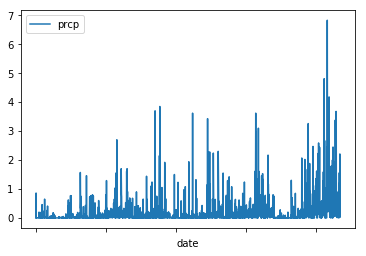

In [10]:
precipitation_df.plot()
plt.savefig('precipitation.png')

In [11]:
precipitation_df.describe()

,prcp
count,2175.000000
mean,0.199200
std,0.484478
min,0.000000
25%,0.000000
50%,0.020000
75%,0.160000
max,6.830000


In [12]:
session.query(station.name).count()

9

In [13]:
session.execute('SELECT * FROM Stations').fetchall()

[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [14]:
inspector = inspect(engine)

In [15]:
columns = inspector.get_columns('Stations')

In [16]:
for column in columns:
    print(column["name"], column["type"])

station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
columns2 = inspector.get_columns('Measurements')
for column in columns2:
    print(column["name"], column["type"])

id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs FLOAT


In [18]:
session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(-func.count(measurement.station)).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [19]:
most_active = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(-func.count(measurement.station)).first()
most_active[0]

'USC00519281'

In [20]:
results = session.query(measurement.date, measurement.tobs).filter(measurement.date.between('2015-01-01','2015-12-31'), measurement.station == most_active[0]).all() 

In [21]:
temp_df = pd.DataFrame(results)
temp_df.head()

,date,tobs
0,2015-01-01,66.0
1,2015-01-02,60.0
2,2015-01-03,67.0
3,2015-01-04,65.0
4,2015-01-05,56.0


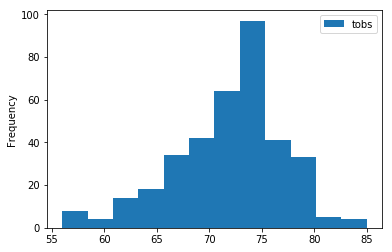

In [22]:
temp_df.plot(kind='hist', bins= 12)
plt.savefig('temp_histogram.png')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000173719A8C88>]],
      dtype=object)

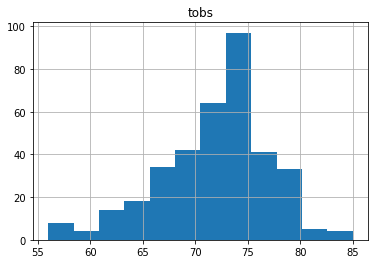

In [23]:
temp_df.hist(bins=12)


In [24]:
def calc_temps(start, end):
    average = session.query(func.avg(measurement.tobs)).filter(measurement.date.between(start, end)).all()
    maximum = session.query(func.max(measurement.tobs)).filter(measurement.date.between(start, end)).all()
    minimum = session.query(func.min(measurement.tobs)).filter(measurement.date.between(start, end)).all()
    return average, maximum, minimum
    

In [25]:
session.execute('SELECT date FROM Measurements LIMIT 5').fetchall()

[('2010-01-01',),
 ('2010-01-02',),
 ('2010-01-03',),
 ('2010-01-04',),
 ('2010-01-07',)]

In [26]:
trip_temps = calc_temps('2015-01-01','2015-12-31')

In [27]:
barheight = trip_temps[0][0][0]

In [28]:
tmin = trip_temps[2][0][0]
tmax = trip_temps[1][0][0]

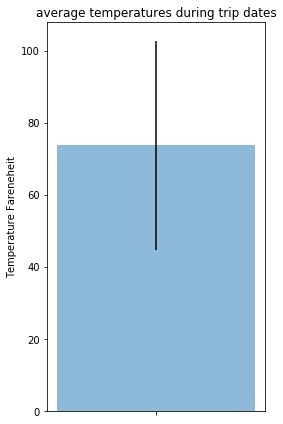

In [41]:
plt.figure(figsize=(4, 6))
plt.bar('', barheight, yerr= (tmax - tmin), alpha = .5)
plt.title('average temperatures during trip dates')
plt.ylabel('Temperature Fareneheit')
plt.tight_layout()
plt.savefig('trip_temp_bar.png')

In [ ]:
rain_by_station = session.query(measurement.station, func.sum(measurement.prcp)).filter(measurement.date.between('2015-01-01','2015-12-31')).group_by(measurement.station).order_by(func.sum(measurement.prcp)).all()

In [ ]:
pd.DataFrame(rain_by_station, columns= ['Station', 'total rainfail 2015'])

In [ ]:
import numpy as np

def daily_normals(date):
    yearlist = ['2010', '2011', '2012', '2013', '2014', '2015', '2016']
    averagelist = []
    maxlist = []
    minlist = []

    for year in yearlist:
        average = session.query(func.avg(measurement.tobs)).filter(measurement.date == year + date).all()
        maximum = session.query(func.max(measurement.tobs)).filter(measurement.date == year + date).all()
        minimum = session.query(func.min(measurement.tobs)).filter(measurement.date == year + date).all()
        averagelist.append(int(average[0][0]))
        maxlist.append(int(maximum[0][0]))
        minlist.append(int(minimum[0][0]))
    result1 = round(np.mean(averagelist), 2)
    result2 = round(np.mean(maxlist), 2)
    result3 = round(np.mean(minlist), 2)
    #print(f'avg: {result1}')
    #print(f'max: {result2}')
    #print(f'min: {result3}')
    return result1, result2, result3

In [ ]:
daily_normals('-04-02')

In [ ]:
trip_date_list = ['-12-01', '-12-02', '-12-03','-12-04', '-12-05', '-12-06', '-12-07', '-12-08', '-12-09', '-12-10', '-12-11', '-12-12', '-12-13', '-12-14', '-12-15']
dailys_list = []
date_list = []
for date in trip_date_list:
    result = daily_normals(date)
    dailys_list.append(result)
    date_list.append(date[1:])

In [ ]:
trip_dailys_df = pd.DataFrame(dailys_list, columns=['average', 'high', 'low'], index=date_list)
trip_dailys_df['date'] = date_list
trip_dailys_df

In [ ]:
print(plt.style.available)
plt.style.use('seaborn-bright')

In [ ]:
ax = trip_dailys_df.plot(kind='area', stacked=False, figsize=(10, 5))
ax.set_xticklabels(trip_dailys_df['date'])
plt.xticks(np.arange(len(trip_dailys_df['date'])), rotation= 45)
plt.xlabel('date')
plt.ylabel('temperature F')
plt.title('Temperature Daily Normals for Trip Dates')
plt.xlim()